In [1]:
## last update July 2024, @moon

In [2]:
import os
import numpy as np
import pylab as plt
import pandas as pd
import json
from scipy import interpolate
from scipy.signal import hilbert


In [3]:
def RFBM_coordinates(rf_size, depth, dX, RefX, bm_scale=1):
    """
    Cartesian and Polar grids for BM and RF frames captured by BK3500 ultrasound machine
    inputs
        rf_size: the shape of a single frame RF
        depth: the acquisition depth [cm]
        dX: BM pixel size extracted from DICOM frame [cm]
        RefX: BM reference point in x axis extracted from DICOM frame [pixel]
        bm_scale: scale factor to chnage BM resolution
    outputs
        BM_physical_grids: list of BM grids for Cartesian (X axis [cm], Y axis [cm])
        and Polar (theta axis [Rad], R axis [cm]) coordinates
        RF_physical_grids: list of RF grids for Polar (theta axis [Rad], R axis [cm])
        and Cartesian (X axis [cm], Y axis [cm]) coordinates
        boundaries: frame boundary masks for BM and RF images
    note:
        tested for biopsy needle located at the top left of the RF and BM frame
    author: @moon
    updated: August 2023
    """
    #### fix prob dimensions
    PRB_RADIUS = 0.01055 *100
    PRB_ANGLE = np.radians(151)
    BM_FRAME_H = 616
    BM_FRAME_W = 756

    nR=rf_size[0]
    nTheta=rf_size[1]

    min_r = PRB_RADIUS
    max_r = PRB_RADIUS + depth

    min_theta = -PRB_ANGLE/2
    max_theta = +PRB_ANGLE/2

    rc = np.linspace(min_r,max_r,nR)
    thc = np.linspace(min_theta, max_theta, nTheta)

    nY = int(round(bm_scale*BM_FRAME_H))
    nX = int(round(bm_scale*BM_FRAME_W))
    shiftX = int(round(bm_scale*RefX))
    bm_spacing = dX/bm_scale

    x = (np.arange(nX)-shiftX)*bm_spacing
    x = np.sort(-x)
    minX, maxX = x.min(), x.max()

    maxY = PRB_RADIUS + depth
    y = np.arange(nY)*bm_spacing
    y = y-y.max()+maxY
    minY = y.min()

    xSR,ySR=np.meshgrid(x, y)

    pth=np.arctan(xSR/ySR)
    pr=np.sqrt(np.power(xSR,2)+np.power(ySR,2))
    
    tSR, rSR = np.meshgrid(thc, rc)            

    sinth = np.sin(tSR)
    costh = np.cos(tSR)
    px = rSR * sinth
    py = rSR * costh

    BM_physical_grids = [xSR,ySR, pth,pr] 
    RF_physical_grids = [tSR,rSR, px,py]
    
    ## define the border masks for image coordinates
    BM_mask = (pth>=min_theta)*(pth<=max_theta)*(pr>=min_r)*(pr<=max_r)
    RF_mask = (px>=minX)*(px<=maxX)*(py>=minY)*(py<=maxY)
    boundaries = [BM_mask, RF_mask]

    return BM_physical_grids, RF_physical_grids, boundaries


In [4]:
## JSON DICT PARAMETERs
items_list = ['id', 'CoreName', 'CoreId', 'Pathology', 'TrueLabel', 'GleasonScore',
                'PrimarySecondary', 'LengthAll', 'CoreL', 'Involvement', 'PerineuralInvasion',
                'ExtraprostaticExtension', 'IntraductalCarcinoma', 'PatientId', 'Revert',
                'Depth', 'Bfreq', 'Freq', 'DataFreq', 'IQFreq', 'RFWidth',
                'RFHight', 'dX', 'ReferenceX', 'PSA', 'Prostate size']


In [5]:
## DATA PATH
folder = "/projects/bk_pca/BK_QUEENS_CORES/"


In [6]:
## LOAD CORE DATA
core_name = r"pat2007_cor5"

info_file = os.path.join(folder, core_name+'_info.json')
rf_file = os.path.join(folder, core_name+'_rf.npy')
needle_file = os.path.join(folder, core_name+'_needle.npy')
bmode_needle_file = os.path.join(folder, core_name+'_needle_bm.npy')
prostate_file = os.path.join(folder, core_name+'_prostate.npy')

with open(info_file, 'r') as file:
    info = json.load(file)
needle = np.load(needle_file) 
rf = np.load(rf_file)
prostate = np.load(prostate_file)
bmode_needle = np.load(bmode_needle_file)


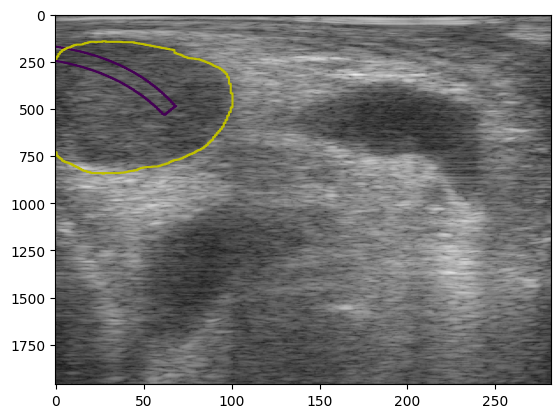

In [7]:
## VISUALIZE IN RF COORDINATES
bmode_rf = np.log(1+np.abs(hilbert(rf[:,:,0])))
plt.imshow(bmode_rf, cmap='gray', aspect='auto')
plt.contour(needle)
plt.contour(prostate, colors='y')
plt.show()


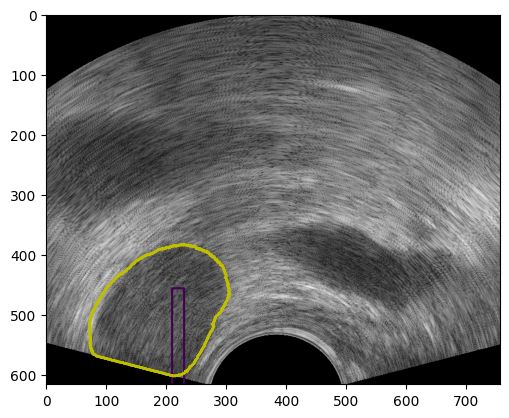

In [8]:
## VISUALIZE IN BM COORDINATES
BM_physical_grids, RF_physical_grids, boundaries = RFBM_coordinates(
    [2 * info["RFWidth"], info["RFHight"]],
    info["Depth"],
    info["dX"],
    info["ReferenceX"],
)

bmode = interpolate.griddata(
    (RF_physical_grids[0].flatten(), RF_physical_grids[1].flatten()),
    bmode_rf.flatten(),
    (BM_physical_grids[2], BM_physical_grids[3]),
    method="nearest",
)
bmode[~boundaries[0]] = 0
bmode = np.flipud(bmode)

bmode_prostate = interpolate.griddata(
    (RF_physical_grids[0].flatten(), RF_physical_grids[1].flatten()),
    prostate.flatten(),
    (BM_physical_grids[2], BM_physical_grids[3]),
    method="nearest",
)
bmode_prostate[~boundaries[0]] = 0
bmode_prostate = np.flipud(bmode_prostate)

plt.imshow(bmode, cmap="gray")
plt.contour(bmode_needle)
plt.contour(bmode_prostate, colors="y")
plt.show()